In [34]:
# Import required libraries and set folder path
import pandas as pd
import numpy as np
import os,sys,re
import matplotlib.pyplot as plt

%matplotlib inline

os.chdir('C:/Users/arpit.goel/Documents/Projects/Kaggle/28_ResearchMatch/')

In [29]:
#Import all rawdata
df_info_train=pd.read_csv('01.RawData/information_train.csv',delimiter='\t',parse_dates=['pub_date'],index_col=['pmid'])
df_info_test=pd.read_csv('01.RawData/information_test.csv',delimiter='\t',parse_dates=['pub_date'],index_col=['pmid'])
df_train=pd.read_csv('01.RawData/train.csv')
df_test=pd.read_csv('01.RawData/test.csv')
df_subm=pd.read_csv('01.RawData/sample_submission_eSUXEfp.csv')

(3522, 8)
abstract         0.000000
article_title    0.000000
author_str       0.122942
pmid             0.000000
pub_date         0.000000
set              0.000000
full_Text        0.959966
year             0.000000
dtype: float64


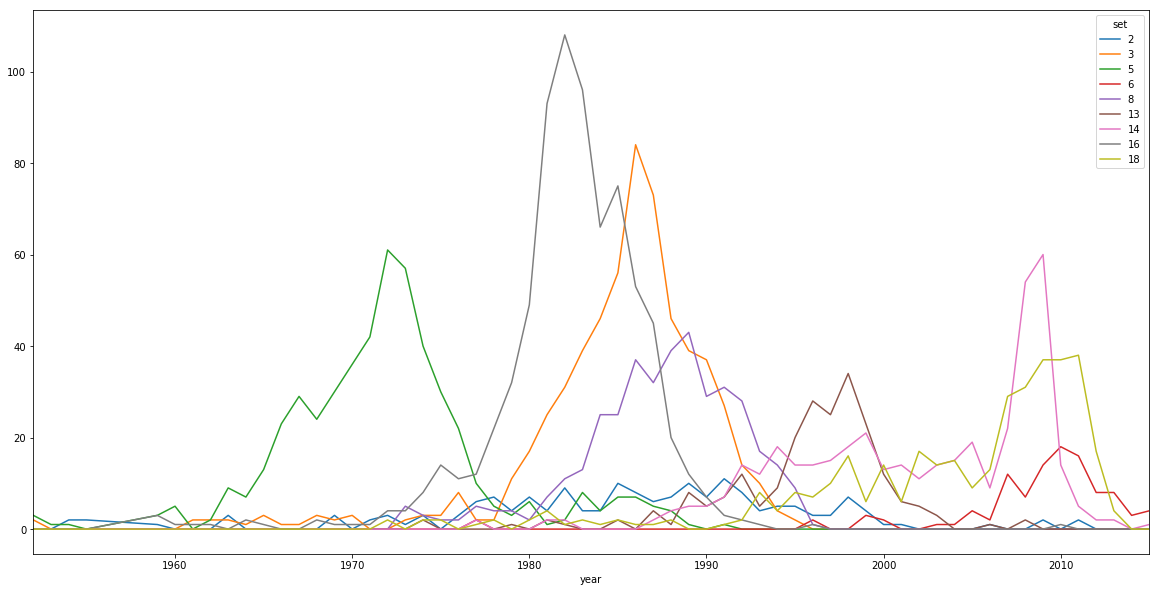

In [25]:
# Profile Train info dataset
print df_info_train.shape
print df_info_train.isnull().mean()
df_info_train['year']=df_info_train.pub_date.dt.year
df_info_train.groupby(['year','set'])['abstract'].count().unstack().fillna(0).plot(figsize=(20,10))

# Features to build: 
# TFIDF based in abstract, article_title
# Extract author_str
# Differnce of pub_date
# Number of atricles published in the past will help get number of recommendations
# recommendations by same author in previous years
# Number of common authors

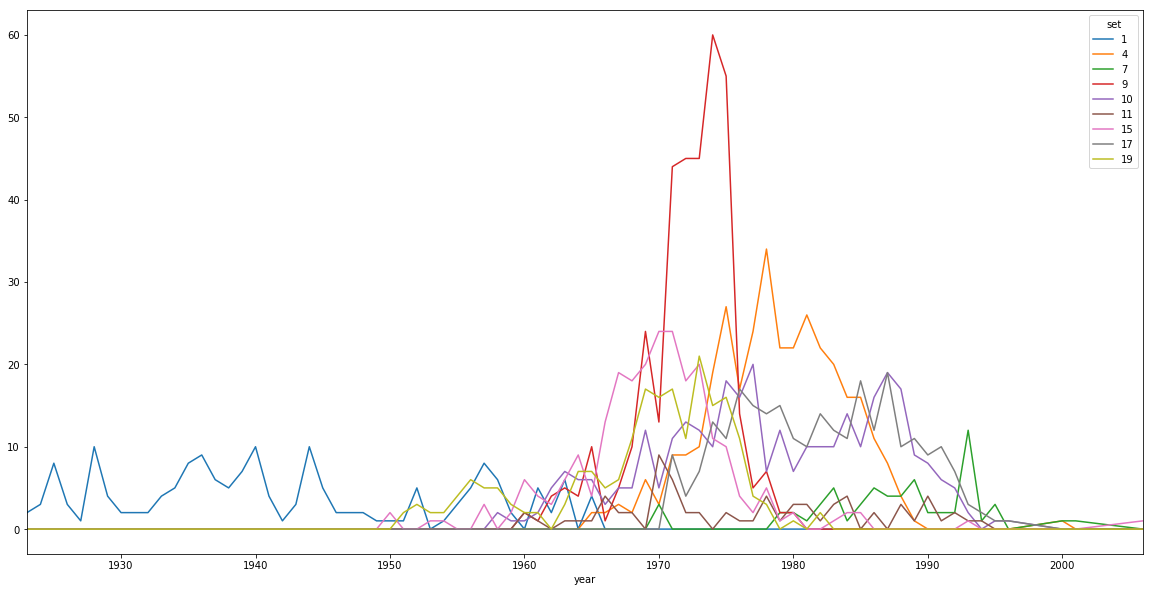

In [120]:
df_info_test['year']=df_info_test.pub_date.dt.year

df_info_test.groupby(['year','set'])['abstract'].count().unstack().fillna(0).plot(figsize=(20,10))


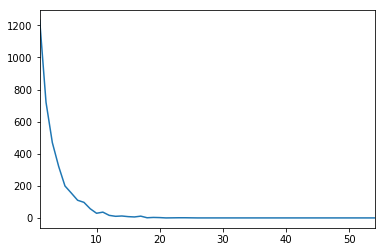

In [51]:
# Check the train set for profiling number of citations
df_train['ref_list_parse']=df_train['ref_list'].map(lambda x: map(int,re.sub('[^0-9,]','',x).split(',')))
df_train['num_citations']=df_train['ref_list_parse'].map(lambda x: len(x))
df_train['num_citations'].value_counts().sort_index().plot()

In [124]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.05,min_df=2,ngram_range=(1,1))

In [116]:
# Make flat file for citation indicator
citations=[pd.Series(x[1]['ref_list_parse'],index=[x[1]['pmid']]*x[1]['num_citations']) for x in df_train.iterrows()]
citations=pd.concat(citations).to_frame('pmid_citation')
citations.index.name='pmid'
citations=citations.reset_index()
citations['flag_citation']=1

citation_master=df_info_train[['set','pub_date']].reset_index()
citation_master=pd.merge(citation_master,citation_master,on=['set'],suffixes=['','_citation'])
citation_master=citation_master[citation_master['pmid']!=citation_master['pmid_citation']]
citation_master=pd.merge(citation_master,citations,how='left',on=['pmid','pmid_citation'])
citation_master['flag_citation']=citation_master['flag_citation'].fillna(0)

#This filter removed 529 citation records
citation_master=citation_master[citation_master['pub_date']>citation_master['pub_date_citation']]

#Keep only 5 percent of the negatives
np.random.seed(1234)
citation_master['random']=np.random.random(len(citation_master))
citation_master['keep']=citation_master['random']<0.05
citation_master=citation_master[citation_master[['keep','flag_citation']].max(axis=1)>0]

In [118]:
citation_master['flag_citation'].mean()

0.20550379765779922

In [121]:
df_info_train.sort_values(by='pub_date')

,abstract,article_title,author_str,pub_date,set,full_Text
pmid,,,,,,
14915949,ImagesFig. 1.Fig. 2.,Studies on yeast metabolism. 1. Fractionation ...,"W. E. Trevelyan, J. S. Harrison",1952-01-01,3,NaN
14915950,ImagesFig. 4.,Studies on yeast metabolism. 2. Synthesis of c...,"W. E. Trevelyan, J. N. Gammon, E. H. Wiggins, ...",1952-01-01,3,NaN
12981220,Poliomyelitis virus was propagated in vitro su...,STUDIES ON THE PROPAGATION IN VITRO OF POLIOMY...,"Jerome T. Syverton, William F. Scherer",1952-09-30,5,NaN
12981221,"The growth of poliomyelitis virus, Type 2, Yal...",STUDIES ON THE PROPAGATION IN VITRO OF POLIOMY...,"William F. Scherer, Jerome T. Syverton",1952-09-30,5,NaN
12981222,"Cells like fibroblasts, having no resemblance ...",STUDIES ON THE PROPAGATION IN VITRO OF POLIOMY...,"William F. Scherer, Jerome T. Syverton",1952-09-30,5,NaN
13052828,The cells of a human epithelial cancer cultiva...,STUDIES ON THE PROPAGATION IN VITRO OF POLIOMY...,"William F. Scherer, Jerome T. Syverton, George...",1953-05-01,5,NaN
13130789,Lysine-ε-C14-labeled plasma proteins produced ...,SYNTHESIS OF ALL PLASMA PROTEIN FRACTIONS EXCE...,"Leon L. Miller, William F. Bale",1954-01-31,2,NaN
13130790,"The non-hepatic tissues in a perfused ""carcass...",PLASMA AND TISSUE PROTEINS PRODUCED BY NON-HEP...,"Leon L. Miller, C. G. Bly, William F. Bale",1954-01-31,2,NaN
13130792,Plaques have been produced with the three type...,PLAQUE FORMATION AND ISOLATION OF PURE LINES W...,"R. Dulbecco, Marguerite Vogt",1954-01-31,5,NaN
